In [8]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
# Peak detection and gaussian on the histogram of the image heights

# H
# |          =               
# |          = =            
# |  =     = = =              
# |  =     = = = =             
# |= =   = = = = =      =        
# |= = = = = = = = =  = = =         
# \ - - - - - - - - - - - - X



In [ ]:
# Identify the background
#   Generate mask
#   Estimate polynomial background
# Determine 1-D background offsets from the raw data within the mask
# Subtract the 1-D offsets from the raw data followed by a single masked background flattening.

PNG
shape: (1024, 1024)


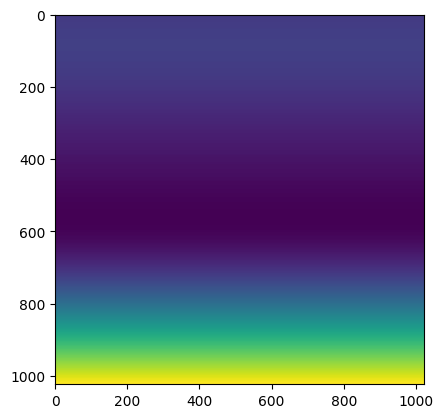

In [9]:
file_name = 'images/slant_3.png'
im = Image.open(file_name)
print(im.format)
im_array = np.array(im, dtype=float)
im_array = im_array[:, :, 0]
print(f'shape: {im_array.shape}')
plt.imshow(im_array)